In [1]:
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
breast_cancer_wisconsin_diagnostic = fetch_ucirepo(id=17) 
  
# data (as pandas dataframes) 
X = breast_cancer_wisconsin_diagnostic.data.features 
y = breast_cancer_wisconsin_diagnostic.data.targets 

Best Parameters: {'C': 0.1, 'class_weight': {0: 1, 1: 2}, 'penalty': 'l2', 'solver': 'lbfgs'}
Best Recall Score: 0.9695865954066155
Confusion Matrix of Uncalibrated Model:


<Figure size 1000x800 with 0 Axes>

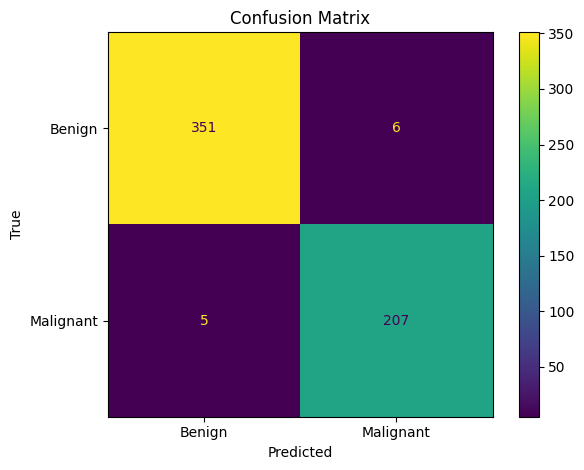

Classification Report for Matrix above:
              precision    recall  f1-score   support

      Benign       0.99      0.98      0.98       357
   Malignant       0.97      0.98      0.97       212

    accuracy                           0.98       569
   macro avg       0.98      0.98      0.98       569
weighted avg       0.98      0.98      0.98       569

Confusion Matrix of Calibrated Model:


<Figure size 1000x800 with 0 Axes>

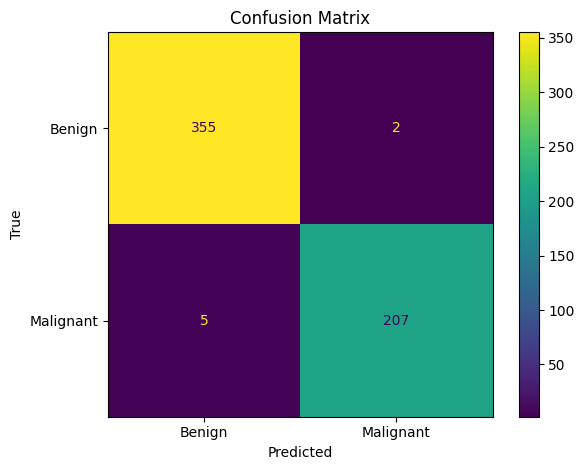

Classification Report for Matrix above:
              precision    recall  f1-score   support

      Benign       0.99      0.99      0.99       357
   Malignant       0.99      0.98      0.98       212

    accuracy                           0.99       569
   macro avg       0.99      0.99      0.99       569
weighted avg       0.99      0.99      0.99       569

Decision Boundaries:


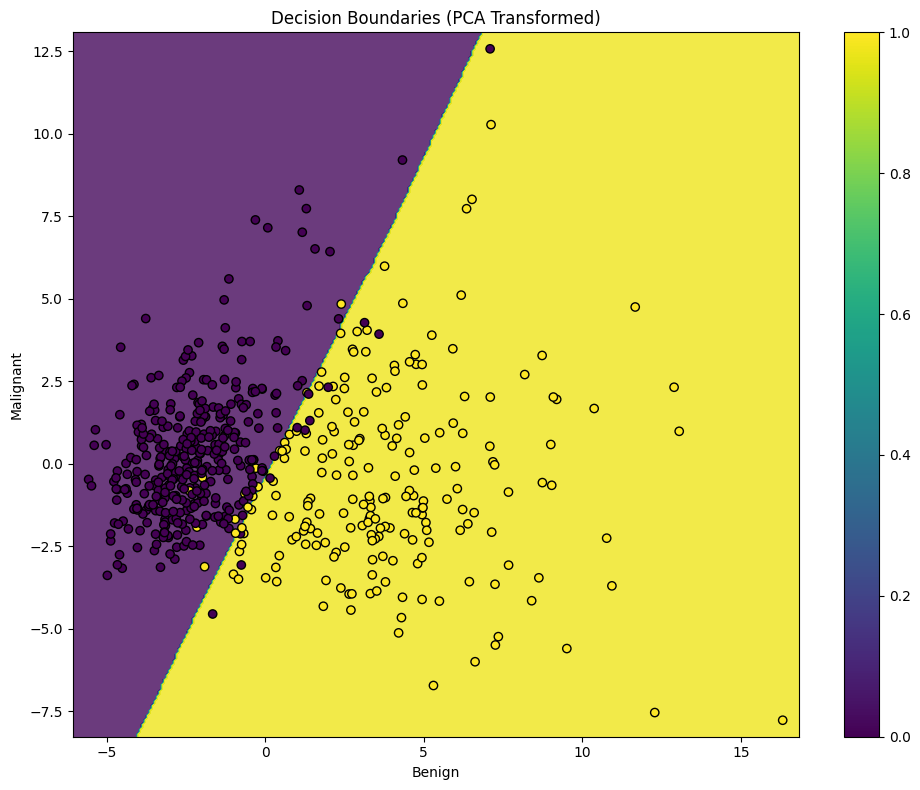

Precision-Recall Curve:


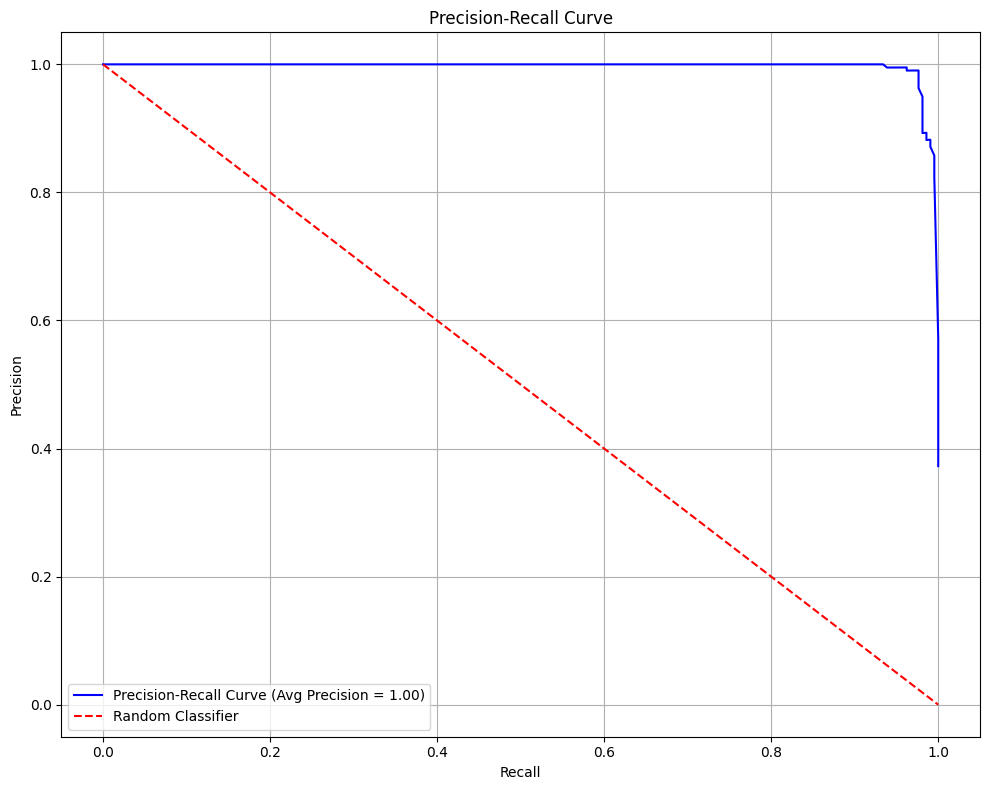

Confusion Matrix with Higher Recall Threshold:


<Figure size 1000x800 with 0 Axes>

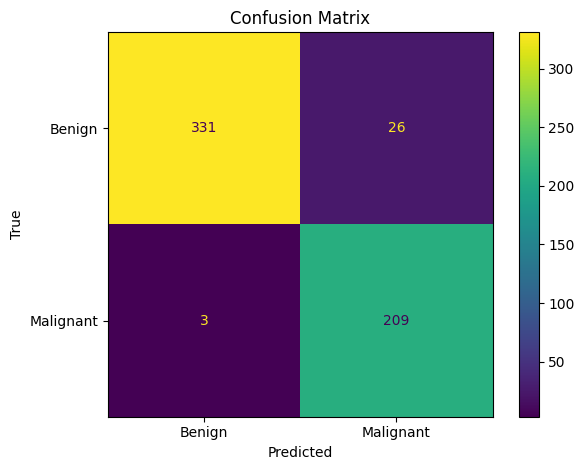

Classification Report for Matrix above:
              precision    recall  f1-score   support

      Benign       0.99      0.93      0.96       357
   Malignant       0.89      0.99      0.94       212

    accuracy                           0.95       569
   macro avg       0.94      0.96      0.95       569
weighted avg       0.95      0.95      0.95       569

Confusion Matrix with even Higher Recall Threshold:


<Figure size 1000x800 with 0 Axes>

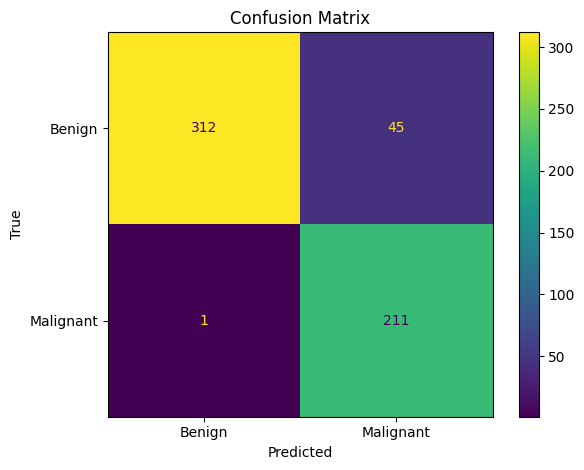

Classification Report for Matrix above:
              precision    recall  f1-score   support

      Benign       1.00      0.87      0.93       357
   Malignant       0.82      1.00      0.90       212

    accuracy                           0.92       569
   macro avg       0.91      0.93      0.92       569
weighted avg       0.93      0.92      0.92       569

Confusion Matrix with Extreme Recall Threshold:


<Figure size 1000x800 with 0 Axes>

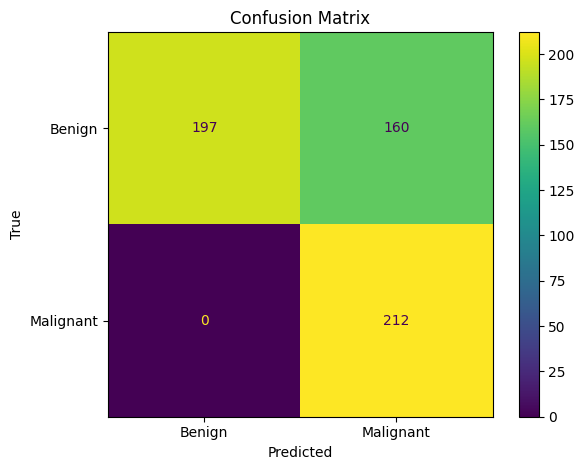

Classification Report for Matrix above:
              precision    recall  f1-score   support

      Benign       1.00      0.55      0.71       357
   Malignant       0.57      1.00      0.73       212

    accuracy                           0.72       569
   macro avg       0.78      0.78      0.72       569
weighted avg       0.84      0.72      0.72       569

Confusion Matrix with Higher Precision Threshold:


<Figure size 1000x800 with 0 Axes>

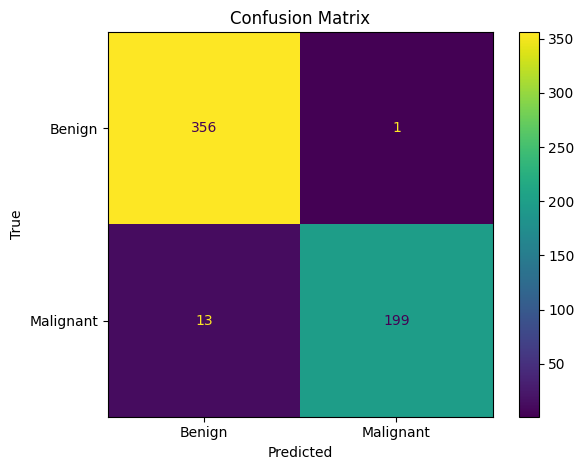

Classification Report for Matrix above:
              precision    recall  f1-score   support

      Benign       0.96      1.00      0.98       357
   Malignant       0.99      0.94      0.97       212

    accuracy                           0.98       569
   macro avg       0.98      0.97      0.97       569
weighted avg       0.98      0.98      0.98       569

Confusion Matrix with even Higher Precision Threshold:


<Figure size 1000x800 with 0 Axes>

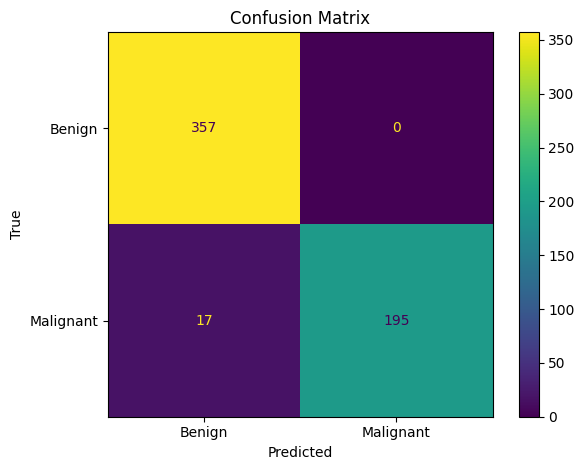

Classification Report for Matrix above:
              precision    recall  f1-score   support

      Benign       0.95      1.00      0.98       357
   Malignant       1.00      0.92      0.96       212

    accuracy                           0.97       569
   macro avg       0.98      0.96      0.97       569
weighted avg       0.97      0.97      0.97       569

Confusion Matrix with even Higher Precision Threshold:


<Figure size 1000x800 with 0 Axes>

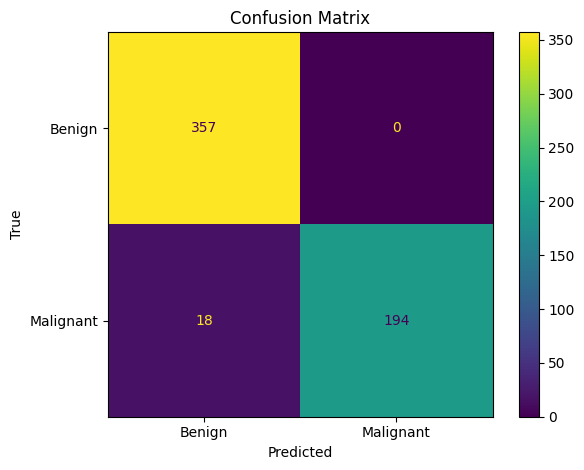

Classification Report for Matrix above:
              precision    recall  f1-score   support

      Benign       0.95      1.00      0.98       357
   Malignant       1.00      0.92      0.96       212

    accuracy                           0.97       569
   macro avg       0.98      0.96      0.97       569
weighted avg       0.97      0.97      0.97       569



In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import (
    classification_report, 
    confusion_matrix,
    ConfusionMatrixDisplay,
    make_scorer,
    precision_recall_curve,
    average_precision_score,
    precision_score, 
    recall_score, 
    f1_score,
)

class BreastCancerModel:
    def __init__(self, X, y, test_size=0.3, random_state=42):
        self.random_state = random_state
        
        # handle pandas data types
        if isinstance(y, pd.DataFrame):
            y = y['Diagnosis'].map({'M': 1, 'B': 0})
        elif isinstance(y, pd.Series):
            y = y.map({'M': 1, 'B': 0})
        
        # normalise (center and scale to unit variance)
        self.scaler = StandardScaler()
        X_scaled = pd.DataFrame(
            self.scaler.fit_transform(X), 
            columns = X.columns, 
            index = X.index
        )
        
        # store scaled data
        self.X = X
        self.X_scaled = X_scaled
        self.y = y

    # use custom scorer with 70/30 split of recall and precision
    def _custom_scoring(self, y_true, y_score):
        y_pred = (y_score >= 0.5).astype(int)
        recall = recall_score(y_true, y_pred, zero_division=0)
        precision = precision_score(y_true, y_pred, zero_division=0)
        f1 = f1_score(y_true, y_pred, zero_division=0)
        return 0.7 * recall + 0.3 * precision # can change split and/or add f1
    
    def _tune(self, model, param_grid):
        
        # use stratified 5-fold cross-validation
        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=self.random_state)

        custom_scorer = make_scorer(self._custom_scoring, needs_proba=True)
        grid_search = GridSearchCV(model, param_grid, cv=cv, scoring=custom_scorer, n_jobs=-1)
        
        grid_search.fit(self.X_scaled, self.y)
        
        print("Best Parameters:", grid_search.best_params_)
        print("Best Recall Score:", grid_search.best_score_)
        
        return grid_search.best_estimator_

    def train_model(self):
        
        # parameter grid of parameters to test
        param_grid = {
            'C': np.logspace(-4, 3, 8),
            'class_weight': [None, 'balanced', {0:1, 1:2}, {0:1, 1:3}, {0:2, 1:1}, {0:3, 1:1}],
            'penalty': ['l2'],
            'solver': ['lbfgs', 'liblinear', 'saga']
        }
        
        # tune model
        model = self._tune(LogisticRegression(random_state=self.random_state, max_iter=20000), param_grid)
        
        return model

    def calibrate_model(self, model, method='sigmoid'):
        calibrated_model = CalibratedClassifierCV(model, cv=5, method=method)
        calibrated_model.fit(self.X_scaled, self.y)
        return calibrated_model

    # adjust thershold (bigger -> more precise)
    def adjust_classification_threshold(self, model, threshold=0.5):
        def custom_predict(X):
            proba = model.predict_proba(X)[:, 1]
            return (proba >= threshold).astype(int)
        
        return custom_predict

    def plot_confusion_matrix(self, model, predict_func=None):
        
        # allows for plotting calibrated
        if predict_func:
            y_pred = predict_func(self.X_scaled)
        else:
            y_pred = model.predict(self.X_scaled)
        
        cm = confusion_matrix(self.y, y_pred)
        
        # make plot
        plt.figure(figsize=(10, 8))
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Benign', 'Malignant'])
        disp.plot()
        plt.title('Confusion Matrix')
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.tight_layout()
        plt.show()
        
        # print classification report
        print("Classification Report for Matrix above:")
        print(classification_report(self.y, y_pred, target_names=['Benign', 'Malignant'], zero_division=0, labels=[0, 1]))

    def plot_decision_boundaries(self, model):
        # PCA for 2d
        pca = PCA(n_components=2)
        X_pca = pca.fit_transform(self.X_scaled)
        
        # meshgrid
        x_min, x_max = X_pca[:, 0].min() - 0.5, X_pca[:, 0].max() + 0.5
        y_min, y_max = X_pca[:, 1].min() - 0.5, X_pca[:, 1].max() + 0.5
        xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300), np.linspace(y_min, y_max, 300))
        
        # Predict for each point in the mesh
        Z = model.predict(pca.inverse_transform(np.c_[xx.ravel(), yy.ravel()]))
        Z = Z.reshape(xx.shape)

        # Plotting
        plt.figure(figsize=(10, 8))
        contour = plt.contourf(xx, yy, Z, alpha=0.8, levels=np.linspace(Z.min(), Z.max(), 20))
        scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=self.y, edgecolor='black')
        
        plt.title('Decision Boundaries (PCA Transformed)')
        plt.xlabel('Benign')
        plt.ylabel('Malignant')
        plt.colorbar(scatter)
        plt.tight_layout()
        plt.show()

    def plot_precision_recall_curve(self, model):
        
        y_scores = model.predict_proba(self.X_scaled)[:, 1]
        precisions, recalls, thresholds = precision_recall_curve(self.y, y_scores)
        avg_precision = average_precision_score(self.y, y_scores)
        
        plt.figure(figsize=(10, 8))
        plt.plot(recalls, precisions, color='blue', label=f'Precision-Recall Curve (Avg Precision = {avg_precision:.2f})')
        plt.plot([0, 1], [1, 0], linestyle='--', color='red', label='Random Classifier')
        
        plt.title('Precision-Recall Curve')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.legend(loc='lower left')
        plt.grid(True)
        plt.tight_layout()
        plt.show()

def main(X, y):
    analyser = BreastCancerModel(X, y)
    model = analyser.train_model()
    calibrated_model = analyser.calibrate_model(model, method='isotonic') # isotonic tends to result in better recall, sigmoid for precision

    print("Confusion Matrix of Uncalibrated Model:")
    analyser.plot_confusion_matrix(model)
    print("Confusion Matrix of Calibrated Model:")
    analyser.plot_confusion_matrix(calibrated_model)
    print("Decision Boundaries:")
    analyser.plot_decision_boundaries(calibrated_model)
    print("Precision-Recall Curve:")
    analyser.plot_precision_recall_curve(calibrated_model)

    # example: adjusting threshold to increase precision or recall
    # lower threshold = more recall, higher threshold = more precision
    higher_recall = analyser.adjust_classification_threshold(calibrated_model, threshold=0.1)
    print("Confusion Matrix with Higher Recall Threshold:")
    analyser.plot_confusion_matrix(calibrated_model, predict_func=higher_recall)

    even_higher_recall = analyser.adjust_classification_threshold(calibrated_model, threshold=0.01)
    print("Confusion Matrix with even Higher Recall Threshold:")
    analyser.plot_confusion_matrix(calibrated_model, predict_func=even_higher_recall)
    
    extreme_recall = analyser.adjust_classification_threshold(calibrated_model, threshold=0.001)
    print("Confusion Matrix with Extreme Recall Threshold:")
    analyser.plot_confusion_matrix(calibrated_model, predict_func=extreme_recall)

    higher_precision = analyser.adjust_classification_threshold(calibrated_model, threshold=0.9)
    print("Confusion Matrix with Higher Precision Threshold:")
    analyser.plot_confusion_matrix(calibrated_model, predict_func=higher_precision)

    even_higher_precision = analyser.adjust_classification_threshold(calibrated_model, threshold=0.99)
    print("Confusion Matrix with even Higher Precision Threshold:")
    analyser.plot_confusion_matrix(calibrated_model, predict_func=even_higher_precision)

    extreme_precision = analyser.adjust_classification_threshold(calibrated_model, threshold=0.999)
    print("Confusion Matrix with even Higher Precision Threshold:")
    analyser.plot_confusion_matrix(calibrated_model, predict_func=extreme_precision)

main(X, y)